# Machine Learning 

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings

# filter out warnings from sklearn library
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')


# Load data
X_train= pd.read_csv("../train/pheno_training_treated.csv")

X_test = pd.read_csv("../test/pheno_test_treated.csv")


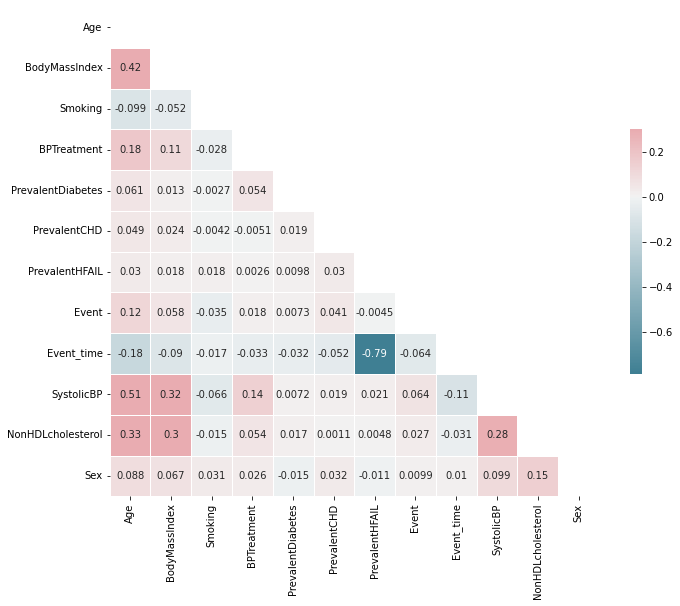

In [143]:
# Compute the correlation matrix
X_train.drop(columns=["Sample_ID"], inplace=True)
X_train = pd.DataFrame(X_train)
corr = X_train.corr()

# Create a mask to hide the upper triangle of the correlation matrix (redundant information)
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()


After assessing the correlation heat map weve decided that there is no significant correlation between any feature with the exception for the feature Event_time and PrevalentHFAIL.
However, because we feel that the event time variable is not relevant to this problem we have decided to remove it.
Therefore, and looking for a model that can predict the probability of a patient having a heart failure, we decided to merge the two variables that give us that information, Event and PrevalentHFAIL, into one to later obtain the predictions in the ML models.

#### Our dataset is unbalanced with many negative cases to very few positive ones, so we decided to take stock of the dataset.


In [144]:
# preprocessing data for machine learning engineer

#X_train.drop(columns=["Sample_ID"], inplace=True)
y_train = X_train.PrevalentHFAIL + X_train.Event # data target with the patients that had HF before and after the first data collecting
y_train = y_train.map({2: 1, 0: 0, 1: 1})
y_train_base = y_train
X_train.drop(columns=[ "PrevalentHFAIL","Event"], inplace=True)

X_test.drop(columns=["Sample_ID"], inplace=True)
y_test = X_test.PrevalentHFAIL + X_test.Event  # data target with the patients that had HF before and after the first data collecting
y_test = y_test.map({2: 1, 0: 0, 1: 1})
y_test_base = y_test
X_test.drop(columns=[ "PrevalentHFAIL","Event"], inplace=True)


# SMOTE is used in unbalanced datasets to balance it
print(f'Original dataset shape {Counter(y_train)}')

# Since our dataset has an unbalanced number of 0 cases and 1 cases SMOTE is used to balance out this metrics making the training part of our model more accurate
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

print(f'Resampled dataset shape {Counter(y_train)}')
print(f'Resampled dataset shape {Counter(y_test)}')

Original dataset shape Counter({0: 3229, 1: 386})
Resampled dataset shape Counter({0: 3229, 1: 3229})
Resampled dataset shape Counter({0: 1628, 1: 181})


#### Selection of the best features

In [145]:
from sklearn.feature_selection import SelectKBest

selector = SelectKBest(k=7)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_select = selector.transform(X_test)

# Get the selected features
selected_features = X_train.columns[selector.get_support()]

# Print the selected features
print(selected_features)

Index(['Age', 'BodyMassIndex', 'BPTreatment', 'PrevalentCHD', 'Event_time',
       'SystolicBP', 'Sex'],
      dtype='object')


In [146]:
# data preparation with selected features from SelectKBest
X_train = X_train.loc[:, selected_features]

X_test = X_test.loc[:, selected_features]



### Standardize data

In [147]:

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Machine learning models

### Logistic Regression

In [148]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

# Define the parameter grid
param_grid = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear']}

# Initialize the model
clf = LogisticRegression(random_state=42)

# Define the accuracy score as the performance metric
acc_scorer = make_scorer(accuracy_score)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, scoring=acc_scorer, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best accuracy score
print("Best parameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)


Best parameters:  {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best accuracy score:  0.6997567105443018


PECC (accuracy): 0.7142067440574903


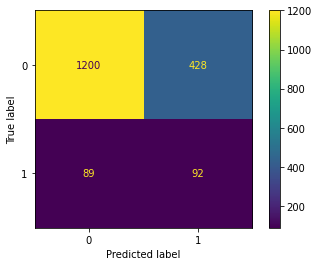

              precision    recall  f1-score   support

           0       0.93      0.74      0.82      1628
           1       0.18      0.51      0.26       181

    accuracy                           0.71      1809
   macro avg       0.55      0.62      0.54      1809
weighted avg       0.86      0.71      0.77      1809



In [149]:
best_params = grid_search.best_params_

# Initialize the model
clf = LogisticRegression(C=best_params["C"], penalty=best_params["penalty"], solver='liblinear')

# Fit the model to the training data
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the PECC accuracy
print("PECC (accuracy):", accuracy_score(y_test, y_pred))

# Plot the confusion matrix
cm_logreg = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=clf.classes_)
disp1.plot()
plt.show()

# print the classification report
print(classification_report(y_test, y_pred))

Cross-validation is a technique used to evaluate the performance of a machine learning model by training the model on different subsets of the data and evaluating its performance on the remaining subsets. The goal of cross-validation is to estimate the performance of a model on unseen data, the cross_val_score function has been used to perform a 5-fold cross-validation on the logistic regression model using the X_train and y_train data. The function returns an array of scores, one for each fold. The average of these scores is the estimated performance of the model on new unseen data. The output of this function is "Accuracy: 0.70 (+/- 0.04)", which means that the average accuracy of the model on the unseen data is 0.70 and the standard deviation of the accuracy is 0.04. This result shows that the model has an average accuracy of 70% and the model's performance varies 4% between the folds

In [150]:
scores = cross_val_score(clf, X_train, y_train, cv=5)

print(f"Accuracy: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")

Accuracy: 0.70 (+/- 0.04)


### Support Vector Machine

In [180]:
from sklearn.svm import SVC

# Define the parameter grid
param_grid = {'C': [0.0001, 0.1, 1],
              'kernel': ['linear', 'rbf'],
              }

# Initialize the SVC model
svc = SVC()

# Initialize the GridSearchCV object
grid_search = GridSearchCV(svc, param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'C': 1, 'kernel': 'rbf'}
Best Score: 0.7267030861429329


Accuracy:  0.6821448313985627


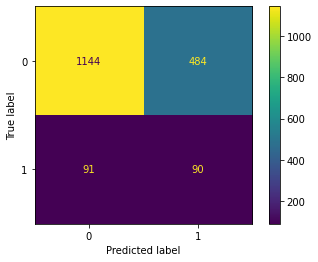

              precision    recall  f1-score   support

           0       0.93      0.70      0.80      1628
           1       0.16      0.50      0.24       181

    accuracy                           0.68      1809
   macro avg       0.54      0.60      0.52      1809
weighted avg       0.85      0.68      0.74      1809



In [183]:


# Initialize the model
clf = SVC(kernel="rbf", random_state=0, C=1)

# Fit the model to the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model's performance
accuracy = clf.score(X_test, y_test)
print("Accuracy: ", accuracy)

# Plot the confusion matrix
cm_logreg = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=clf.classes_)
disp1.plot()
plt.show()

# print the classification report
print(classification_report(y_test, y_pred))


In [152]:
scores = cross_val_score(clf, X_train, y_train, cv=5)

print(f"Accuracy: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")

Accuracy: 0.70 (+/- 0.05)


### Ridge regression

In [184]:
from sklearn.linear_model import RidgeClassifier

model = RidgeClassifier()
param = {
    'solver':['svd', 'cholesky', 'lsqr', 'sag'],
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'fit_intercept':[True, False],
}

search = GridSearchCV(model, param, scoring='neg_mean_absolute_error', n_jobs=-1)

# execute search
result = search.fit(X_train, y_train)

print("Best parameters: ", result.best_params_)
print("Best accuracy score: ", result.best_score_)


Best parameters:  {'alpha': 1e-05, 'fit_intercept': False, 'solver': 'svd'}
Best accuracy score:  -0.30117268155580545


PECC (accuracy): 0.7274737423991156


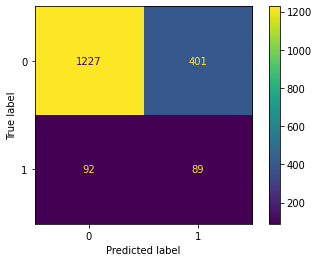

In [185]:


ridge = RidgeClassifier(alpha = 1e-05, fit_intercept = False, solver = 'svd', max_iter=2000)
ridge.fit(X_train, y_train)

ridge_pred = ridge.predict(X_test)
ridge_pred = np.where(ridge_pred > 0.5, 1, 0)

print("PECC (accuracy):", accuracy_score(y_test, ridge_pred))
cm_ridge = confusion_matrix(y_test, ridge_pred)
disp_ridge = ConfusionMatrixDisplay(confusion_matrix=cm_ridge)
disp_ridge.plot()
plt.show()

### KNeighborsClassifier

In [162]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Initialize the model
clf = KNeighborsClassifier()

k_range = list(range(1, 10))
param_grid = dict(n_neighbors=k_range)

# defining parameter range
grid = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)

# fitting the model for grid search
grid_search=grid.fit(X_train, y_train)

print(grid_search.best_params_)
accuracy = grid_search.best_score_ *100
  



Fitting 10 folds for each of 9 candidates, totalling 90 fits
{'n_neighbors': 1}


Accuracy:  0.7805417357656164


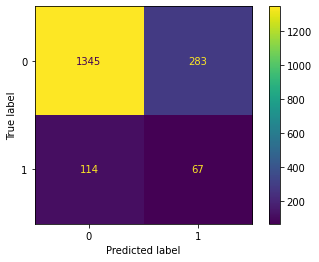

In [156]:
best_k = grid_search.best_params_

# initialize model
clf = KNeighborsClassifier(n_neighbors= best_k["n_neighbors"])

# Fit the model to the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model's performance
accuracy = clf.score(X_test, y_test)
print("Accuracy: ", accuracy)

# plotting the confusion matrix 
cm_kn = confusion_matrix(y_test, y_pred)
disp_kn = ConfusionMatrixDisplay(confusion_matrix=cm_kn)
disp_kn.plot()
plt.show()

### Decision tree

Accuracy score: 0.7810945273631841


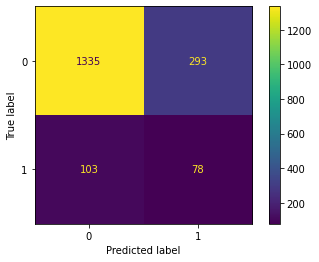

In [157]:
from sklearn.tree import DecisionTreeClassifier

# Initialize
clf = DecisionTreeClassifier()

# Fit the model to the entire training dataset
clf.fit(X_train, y_train)

# Get the predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy score
score = accuracy_score(y_test, y_pred)

# Print the score
print(f'Accuracy score: {score}')


# Plotting the confusion matrix
cm_tree = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=clf.classes_)
disp_tree.plot()
plt.show()


### Gaussian NB

In [186]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

 
# Initialize the model
clf = GaussianNB()

# Define the parameter grid
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best accuracy score
print("Best parameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)



Best parameters:  {'var_smoothing': 1e-09}
Best accuracy score:  0.6565513090147796


Accuracy score: 0.8253178551686015


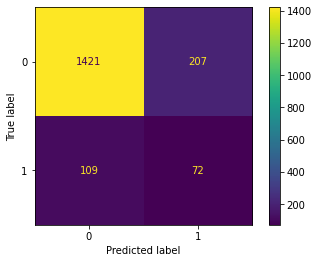

In [187]:
from sklearn.metrics import recall_score

best_params=grid_search.best_params_

clf = GaussianNB(var_smoothing = best_params["var_smoothing"])

# Fit the model to the training data
clf.fit(X_train, y_train)

# Get the predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy score
score = accuracy_score(y_test, y_pred)

# Print the score
print(f'Accuracy score: {score}')


cm_tree = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=clf.classes_)
disp_tree.plot()
plt.show()

## Ensemble
### Voting Classifier

We will use the best 4 models ridge,svm, gauss and logistic models.

Accuracy score: 0.736318407960199


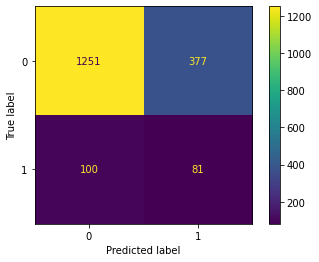

In [200]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

gauss = GaussianNB(var_smoothing=1e-09)
svm = SVC(kernel="rbf", random_state=0, C=0.0001)
#knn_class = KNeighborsClassifier(n_neighbors = 1)
logistic = LogisticRegression(C=1, penalty="l2", solver='liblinear')
ridge = RidgeClassifier(alpha = 1e-05, fit_intercept = False, solver = 'svd', max_iter=2000)
eclf = VotingClassifier(estimators=[('svm', svm), ('log', logistic), ('rg',ridge), ('gau',gauss)], voting='hard')

eclf = eclf.fit(X_train, y_train)

# Get the predictions on the test set
y_pred = eclf.predict(X_test)

score = accuracy_score(y_test, y_pred)

# Print the score
print(f'Accuracy score: {score}')


cm_tree = confusion_matrix(y_test, y_pred, labels=eclf.classes_)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=eclf.classes_)
disp_tree.plot()
plt.show()

#### Stacking Classifier

Accuracy score: 0.7092316196793809


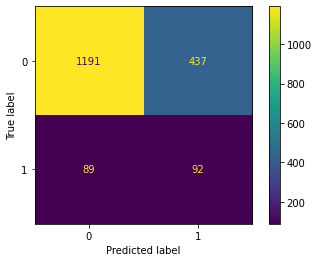

In [202]:
# Create the stacking ensemble
eclf = StackingClassifier(estimators=[('rg', ridge), ('svm', svm), ("gau",gauss)], final_estimator=logistic)

# Fit the ensemble to the training data
eclf.fit(X_train, y_train)

# Get the predictions on the test set
y_pred = eclf.predict(X_test)

score = accuracy_score(y_test, y_pred)

# Print the score
print(f'Accuracy score: {score}')


cm_tree = confusion_matrix(y_test, y_pred, labels=eclf.classes_)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=eclf.classes_)
disp_tree.plot()
plt.show()

#### Random Forest Classifier

In [203]:
from sklearn.model_selection import GridSearchCV  
from sklearn.ensemble import RandomForestClassifier
# Create the parameter grid based on the results of random search 
param_grid = { 
    'n_estimators': [20, 50],
    'max_depth' : [2,4,5],
    'criterion' :['gini', 'entropy'],
    'random_state' : [0,2,4,6,8]
}
# Create a based model
clf = RandomForestClassifier()
# Instantiate the grid search model
CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

print(CV_rfc.best_params_)

{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 50, 'random_state': 0}


Accuracy score: 0.7003869541182974


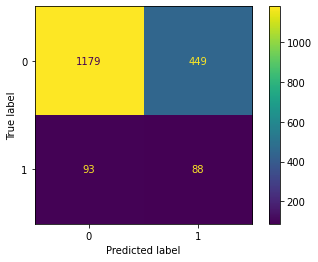

In [204]:


clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

score = accuracy_score(y_test, y_pred)

print(f'Accuracy score: {score}')


cm_tree = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=clf.classes_)
disp_tree.plot()
plt.show()

## Machine learning approach for readcounts dataset
#### Using the organisms present, and knowing in advance which of the individuals have or have had heart failures, we plan to make models to predict the probability of having or not having a heart attack from the organisms present in human gut. Furthermore, we think that combining the two datasets into one could be detrimental to the prediction of a model because they are data with very different features.
